In [89]:
#Load packages

from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
from math import log2

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm




In [2]:
# Set up parameters for data loading from 9 files

data_files = ['PAMAP2_Dataset/Protocol/subject101.dat',  'PAMAP2_Dataset/Protocol/subject102.dat',  'PAMAP2_Dataset/Protocol/subject103.dat',
 'PAMAP2_Dataset/Protocol/subject104.dat',  'PAMAP2_Dataset/Protocol/subject105.dat',  'PAMAP2_Dataset/Protocol/subject106.dat',
  'PAMAP2_Dataset/Protocol/subject107.dat', 'PAMAP2_Dataset/Protocol/subject108.dat', 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  


In [3]:
# load data recursively form 9 files, with column names

df_org = pd.DataFrame()
for file in data_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    df_org = df_org.append(procData, ignore_index=True)

df_org.reset_index(drop=True, inplace=True)
df_org.head()

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


In [4]:
# drop unnecessary columns and rows

df = df_org

df = df.drop(df[df.activityID == 0].index)

df = df.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4', 'chestOrientation1', 
'chestOrientation2', 'chestOrientation3', 'chestOrientation4', 'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 
'ankleOrientation4'],   axis = 1) 

df = df.drop(['timestamp','subject_id'],axis = 1)

df.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [5]:
# Identify columns with null values

df.isnull().sum()

activityID                0
heartrate           1765464
handTemperature       11124
handAcc16_1           11124
handAcc16_2           11124
handAcc16_3           11124
handAcc6_1            11124
handAcc6_2            11124
handAcc6_3            11124
handGyro1             11124
handGyro2             11124
handGyro3             11124
handMagne1            11124
handMagne2            11124
handMagne3            11124
chestTemperature       2420
chestAcc16_1           2420
chestAcc16_2           2420
chestAcc16_3           2420
chestAcc6_1            2420
chestAcc6_2            2420
chestAcc6_3            2420
chestGyro1             2420
chestGyro2             2420
chestGyro3             2420
chestMagne1            2420
chestMagne2            2420
chestMagne3            2420
ankleTemperature       8507
ankleAcc16_1           8507
ankleAcc16_2           8507
ankleAcc16_3           8507
ankleAcc6_1            8507
ankleAcc6_2            8507
ankleAcc6_3            8507
ankleGyro1          

In [6]:
# Perform linear interpolation to replace null values with intermediate values

df = df.interpolate()
for i in range(0,4):
    df["heartrate"].iloc[i]=100

df.isnull().sum()

C:\Users\Rajkumar.Krishnan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


activityID          0
heartrate           0
handTemperature     0
handAcc16_1         0
handAcc16_2         0
handAcc16_3         0
handAcc6_1          0
handAcc6_2          0
handAcc6_3          0
handGyro1           0
handGyro2           0
handGyro3           0
handMagne1          0
handMagne2          0
handMagne3          0
chestTemperature    0
chestAcc16_1        0
chestAcc16_2        0
chestAcc16_3        0
chestAcc6_1         0
chestAcc6_2         0
chestAcc6_3         0
chestGyro1          0
chestGyro2          0
chestGyro3          0
chestMagne1         0
chestMagne2         0
chestMagne3         0
ankleTemperature    0
ankleAcc16_1        0
ankleAcc16_2        0
ankleAcc16_3        0
ankleAcc6_1         0
ankleAcc6_2         0
ankleAcc6_3         0
ankleGyro1          0
ankleGyro2          0
ankleGyro3          0
ankleMagne1         0
ankleMagne2         0
ankleMagne3         0
dtype: int64

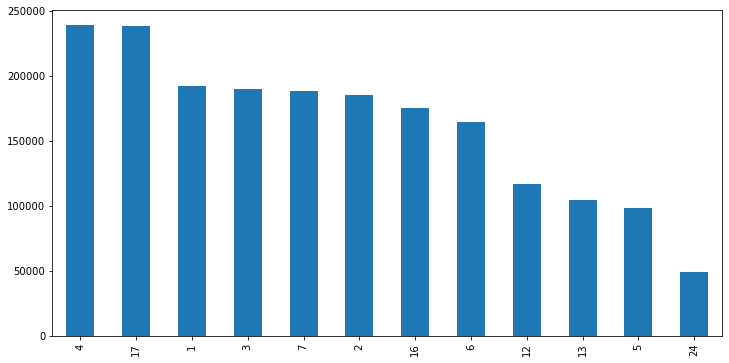

In [8]:
df['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

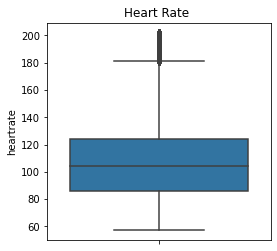

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,4))
plt.title("Heart Rate ")
ax = sns.boxplot(y=df["heartrate"])

<AxesSubplot:xlabel='activityID'>

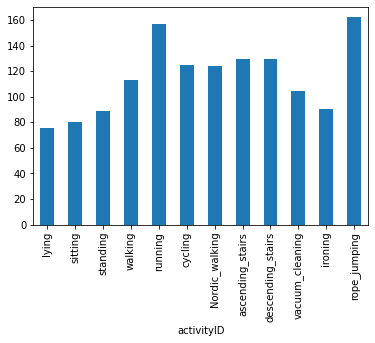

In [10]:
df_hr_act = df['heartrate'].groupby(df['activityID']).mean()
df_hr_act.index = df_hr_act.index.map(activityIDdict)
df_hr_act.plot(kind='bar')

<ipython-input-92-d944ff2ef28b>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap = "PiYG",ax=ax)


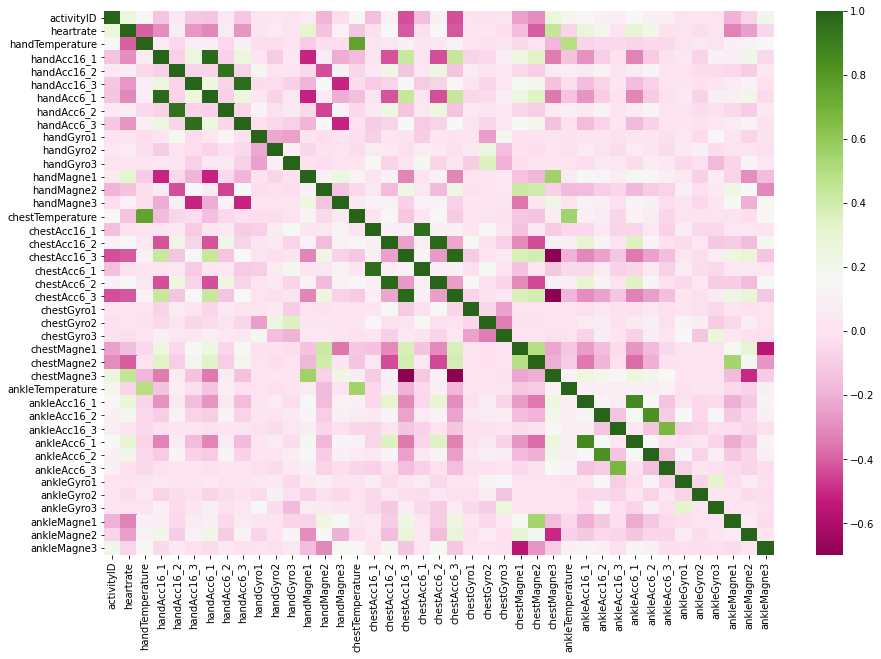

In [92]:
from pandas.plotting import scatter_matrix
df_corr = df.corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap = "PiYG",ax=ax)
plt.show()

In [77]:
#train_df = df.sample(frac=0.8, random_state=1)
#test_df = df.drop(train_df.index)


train_df = df.sample(frac=0.01, random_state=1)
test_df = df.sample(frac=0.01, random_state=1)


In [78]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,RobustScaler

#apply scaling to all columns except subject and activity 
scaler = RobustScaler()
df_scaled = train_df.copy()
df_scaled_test = test_df.copy()

df_scaled.iloc[:,1:41] = scaler.fit_transform(df_scaled.iloc[:,1:41])
df_scaled_test.iloc[:,1:41] = scaler.fit_transform(df_scaled_test.iloc[:,1:41])

df_scaled.head()

,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
452630,3,-0.394737,0.447368,-0.392681,0.222947,-0.570110,-0.365587,0.259001,-0.532428,-0.011928,...,0.322903,0.088302,-0.321792,0.351000,0.214931,0.001144,-0.138216,0.645950,-0.589382,0.650049
191799,12,1.655502,0.236842,-0.735767,-0.099144,-0.205737,-0.634843,-0.106647,-0.256883,-0.866989,...,0.023246,0.824998,-0.269183,-0.186752,-0.822574,3.016822,-0.262059,-0.740749,1.118586,-0.942954
1780187,24,2.000000,0.289474,0.464522,0.039172,-2.005350,0.619760,0.074700,-1.447992,-5.185010,...,1.898381,-7.093870,-0.946144,1.482173,5.455820,-0.771588,-1.204090,-0.443412,-0.432359,-0.691610
1805604,1,-1.131579,0.131579,1.311781,-0.687143,0.896290,1.351788,-0.721202,0.899942,0.065785,...,-0.347634,-5.010393,-2.298743,-0.301961,-0.039485,0.027260,0.035945,0.704890,0.869608,-0.877237
2504609,2,-0.684211,0.500000,0.441019,-2.398863,-0.471713,0.461989,-2.408750,-0.483500,-0.015086,...,-0.104536,-0.186097,0.783086,-0.058229,0.013625,0.068579,0.056550,0.616007,0.512032,0.253206


In [79]:
X_train = df_scaled.drop('activityID', axis=1).values
y_train = df_scaled['activityID'].values

# Test Dataset
X_test = df_scaled.drop('activityID', axis=1).values
y_test = df_scaled['activityID'].values

In [80]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
   
    print("Accuracy: ",acc)
    print("Error: ",acc)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)
    #print("Accuracy: %.3f \nError: %.3f \nPrecesion: %.3f \nRecall: %.3f \nF1:%.3f \n"% (acc,err,p,r,f1) )
    

log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train )
y_pred_lr = log_reg.predict(X_test)
get_metrics(y_test, y_pred_lr)

Accuracy:  0.8191363425806784
Error:  0.8191363425806784
Precision 0.7987946599785589
Recall 0.7877554150547277
F1 0.7922704477328718


C:\Users\Rajkumar.Krishnan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [82]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=5)
dtc.fit(X_train,y_train)
y_pred_dt = dtc.predict(X_test)
get_metrics(y_test,y_pred_dt)

Accuracy:  0.7052344433578671
Error:  0.7052344433578671
Precision 0.6673398185341685
Recall 0.6642501342121474
F1 0.6545647395738058


C:\Users\Rajkumar.Krishnan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
knnc = KNeighborsClassifier(n_neighbors=3)
knnc.fit(X_train,y_train)
y_pred_knnc = knnc.predict(X_test)
get_metrics(y_test,y_pred_knnc)


Accuracy:  0.9470894024396521
Error:  0.9470894024396521
Precision 0.9538751379668929
Recall 0.9347815898233834
F1 0.9426361018677824


In [87]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
get_metrics(y_test,y_pred_svc)

Accuracy:  0.9380822481857017
Error:  0.9380822481857017
Precision 0.9401352230533496
Recall 0.9325741018578736
F1 0.935832202377126


In [90]:
svm = svm.SVC(kernel='linear', C = 1.0)
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
get_metrics(y_test,y_pred_svm)

Accuracy:  0.8783262133923516
Error:  0.8783262133923516
Precision 0.8622176051721472
Recall 0.8502838676041083
F1 0.8546753791223347


In [84]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('lr', log_reg), ('dt', dtc) , ('knn', knnc)], voting='hard')
model.fit(X_train,y_train)

model.score(X_test,y_test)

y_pred_vc = model.predict(X_test)
get_metrics(y_test,y_pred_vc)

C:\Users\Rajkumar.Krishnan\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8792011940913068
Error:  0.8792011940913068
Precision 0.8965967641368352
Recall 0.8481708212123839
F1 0.8597347457068906


In [85]:

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 20
bgmodel = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

bgmodel.fit(X_train,y_train)
y_pred_bgmodel = bgmodel.predict(X_test)
get_metrics(y_test,y_pred_bgmodel)


#results = model_selection.cross_val_score(model, X, Y, cv=kfold)
#print(results.mean())

Accuracy:  0.9998970610942406
Error:  0.9998970610942406
Precision 0.9998463901689708
Recall 0.9998647186147186
F1 0.9998554285908416


In [86]:

from sklearn.ensemble import RandomForestClassifier

seed = 7
num_trees = 20
#max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
rfmodel = RandomForestClassifier(n_estimators=num_trees) #, max_features=max_features)

rfmodel.fit(X_train,y_train)
y_pred_rfmodel = rfmodel.predict(X_test)
get_metrics(y_test,y_pred_rfmodel)



Accuracy:  0.9998970610942406
Error:  0.9998970610942406
Precision 0.9998647135659638
Recall 0.9998093256857401
F1 0.9998369129083242
